# Test Pipeline: Text → Semantic Encoder → Disease Prediction

This notebook tests the full prediction pipeline using **pre-trained models**:

## Contents
1. **Part 1: Setup** - Load trained models and encoders
2. **Part 2: Single Input Test** - Test pipeline with sample text
3. **Part 3: Semantic Encoder Comparison** - Compare different encoder models
4. **Part 4: Interactive Testing** - Custom text input testing

**Pipeline Flow:**
```
Free-form text → Semantic Symptom Encoder → 377-dim symptom vector → Classifier → Disease Predictions
```

**Available Semantic Encoders:**
- `all-MiniLM-L6-v2` (fast, smaller)
- `all-MiniLM-L12-v2` (balanced, default)
- `all-mpnet-base-v2` (highest quality)
- `paraphrase-MiniLM-L6-v2` (paraphrase-focused)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys, os, json, joblib, warnings
import time

warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path(os.getcwd()).parent.parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis


---
# Part 1: Setup - Load Pre-trained Models

In [2]:
from models.architectures.symptom_classifier import SymptomCategoryClassifier, SymptomDiseaseClassifier
from models.architectures.semantic_symptom_encoder import SemanticSymptomEncoder

# Paths
checkpoint_dir = project_root / "models" / "checkpoints"

# Load label encoders
category_encoder = joblib.load(checkpoint_dir / "category_encoder.pkl")
disease_encoder = joblib.load(checkpoint_dir / "disease_encoder.pkl")

# Load symptom columns (feature names)
with open(project_root / "data" / "symptom_vocabulary.json", "r") as f:
    symptom_columns = json.load(f)

print(f"Categories: {len(category_encoder.classes_)}")
print(f"Diseases: {len(disease_encoder.classes_)}")
print(f"Symptom features: {len(symptom_columns)}")

Categories: 14
Diseases: 656
Symptom features: 454


In [3]:
# Load pre-trained classifiers (symptoms-only version)
category_clf = SymptomCategoryClassifier.load(checkpoint_dir / "category_classifier_symptoms.pkl")
disease_clf = SymptomDiseaseClassifier.load(checkpoint_dir / "disease_classifier_symptoms.pkl")

print("✓ Loaded Category Classifier")
print("✓ Loaded Disease Classifier")

✓ Loaded Category Classifier
✓ Loaded Disease Classifier


In [4]:
# Load default semantic encoder
encoder = SemanticSymptomEncoder(model_name="all-MiniLM-L12-v2")
print(f"\n✓ Loaded Semantic Encoder ({encoder.model_name})")

[Encoder] Loading model: all-MiniLM-L12-v2
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 454 symptoms

✓ Loaded Semantic Encoder (all-MiniLM-L12-v2)


---
# Part 2: Single Input Test - Full Pipeline Demo

In [5]:
def predict_from_text(text: str, encoder, category_clf, disease_clf, 
                      category_encoder, disease_encoder, symptom_columns,
                      top_k: int = 5, verbose: bool = True):
    """
    Full pipeline: text → semantic encoder → classifiers → predictions
    
    Returns dict with category and disease predictions.
    """
    start = time.time()
    
    # Step 1: Encode text to symptom vector
    result = encoder.encode_symptoms(text)
    symptom_vector = result["symptom_vector"]
    encode_time = time.time() - start
    
    # Step 2: Prepare feature vector (ensure correct column order)
    # The classifier expects 480 features but encoder outputs 377
    # We need to map symptom_vector to the correct columns
    encoder_symptoms = encoder.symptoms  # 377 symptoms from encoder
    
    # Create full feature vector with zeros
    full_vector = np.zeros(len(symptom_columns), dtype=np.float32)
    
    # Map encoder symptoms to classifier columns
    for i, symptom in enumerate(encoder_symptoms):
        if symptom in symptom_columns:
            col_idx = symptom_columns.index(symptom)
            full_vector[col_idx] = symptom_vector[i]
    
    # Reshape for prediction
    X = full_vector.reshape(1, -1)
    
    # Step 3: Get predictions
    cat_proba = category_clf.predict_proba(X)[0]
    dis_proba = disease_clf.predict_proba(X)[0]
    predict_time = time.time() - start - encode_time
    
    # Get top-k predictions
    cat_top_idx = np.argsort(cat_proba)[::-1][:top_k]
    dis_top_idx = np.argsort(dis_proba)[::-1][:top_k]
    
    cat_predictions = [(category_encoder.classes_[i], cat_proba[i]) for i in cat_top_idx]
    dis_predictions = [(disease_encoder.classes_[i], dis_proba[i]) for i in dis_top_idx]
    
    # Get detected symptoms (above threshold)
    threshold = 0.1
    detected_symptoms = [(encoder.symptoms[i], float(symptom_vector[i])) 
                         for i in np.where(symptom_vector > threshold)[0]]
    detected_symptoms.sort(key=lambda x: x[1], reverse=True)
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"INPUT: {text}")
        print(f"{'='*70}")
        
        print(f"\n⏱️  Timing: encode={encode_time*1000:.1f}ms, predict={predict_time*1000:.1f}ms")
        
        print(f"\n📊 Detected Symptoms (top 10):")
        for symptom, score in detected_symptoms[:10]:
            bar = "█" * int(score * 20)
            print(f"  {symptom:30} {score:.3f} {bar}")
        
        print(f"\n🏥 Category Predictions:")
        for cat, prob in cat_predictions:
            bar = "█" * int(prob * 30)
            print(f"  {cat:25} {prob*100:5.1f}% {bar}")
        
        print(f"\n🩺 Disease Predictions:")
        for dis, prob in dis_predictions:
            bar = "█" * int(prob * 30)
            print(f"  {dis:35} {prob*100:5.1f}% {bar}")
    
    return {
        "text": text,
        "symptom_vector": symptom_vector,
        "detected_symptoms": detected_symptoms,
        "category_predictions": cat_predictions,
        "disease_predictions": dis_predictions,
        "encode_time": encode_time,
        "predict_time": predict_time
    }

In [6]:
# Test with sample inputs
test_texts = [
    "I have a severe headache and feel nauseous. My head is pounding.",
    "I've been coughing for days with chest pain and difficulty breathing.",
    "My stomach hurts after eating, I have heartburn and feel bloated.",
    "I can't sleep at night and feel anxious all the time.",
    "I have a rash on my skin that's red and itchy.",
    "Burning sensation when I urinate and frequent urge to pee."
]

for text in test_texts:
    _ = predict_from_text(
        text, encoder, category_clf, disease_clf,
        category_encoder, disease_encoder, symptom_columns
    )


INPUT: I have a severe headache and feel nauseous. My head is pounding.

⏱️  Timing: encode=307.0ms, predict=5789.9ms

📊 Detected Symptoms (top 10):
  headache                       0.900 █████████████████

🏥 Category Predictions:
  Mental and Behavioral Health  38.1% ███████████
  Unknown Type               10.6% ███
  Endocrine and Metabolic    10.3% ███
  Hematology and Oncology     7.7% ██
  Genitourinary and Reproductive   5.9% █

🩺 Disease Predictions:
  panic disorder                      100.0% █████████████████████████████
  benign paroxysmal positional vertical (bppv)   0.0% 
  seborrheic dermatitis                 0.0% 
  personality disorder                  0.0% 
  marijuana abuse                       0.0% 

INPUT: I've been coughing for days with chest pain and difficulty breathing.

⏱️  Timing: encode=42.2ms, predict=6.5ms

📊 Detected Symptoms (top 10):
  chest pain                     0.900 █████████████████
  cough                          0.900 █████████████████
  d

---
# Part 3: Semantic Encoder Comparison

Compare how different sentence-transformer models affect the pipeline output.

In [7]:
# Available encoder models (based on cached embeddings)
ENCODER_MODELS = [
    "all-MiniLM-L6-v2",      # Fast, smaller
    "all-MiniLM-L12-v2",     # Balanced (default)
    "all-mpnet-base-v2",     # Highest quality
    "paraphrase-MiniLM-L6-v2",  # Paraphrase-focused
    "multi-qa-mpnet-base-dot-v1"
]

print("Loading encoders for comparison...")
encoders = {}
for model_name in ENCODER_MODELS:
    print(f"  Loading {model_name}...")
    encoders[model_name] = SemanticSymptomEncoder(model_name=model_name)

print(f"\n✓ Loaded {len(encoders)} encoder models")

Loading encoders for comparison...
  Loading all-MiniLM-L6-v2...
[Encoder] Loading model: all-MiniLM-L6-v2
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 454 symptoms
  Loading all-MiniLM-L12-v2...
[Encoder] Loading model: all-MiniLM-L12-v2
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 454 symptoms
  Loading all-mpnet-base-v2...
[Encoder] Loading model: all-mpnet-base-v2
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 454 symptoms
  Loading paraphrase-MiniLM-L6-v2...
[Encoder] Loading model: paraphrase-MiniLM-L6-v2
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 454 symptoms
  Loading multi-qa-mpnet-base-dot-v1...
[Encoder] Loading model: multi-qa-mpnet-base-dot-v1
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 454 symptoms

✓ Loaded 5 encoder models


In [8]:
def compare_encoders(text: str, encoders: dict, category_clf, disease_clf,
                     category_encoder, disease_encoder, symptom_columns):
    """
    Compare predictions across different semantic encoders.
    """
    print(f"\n{'='*80}")
    print(f"COMPARING ENCODERS FOR: {text}")
    print(f"{'='*80}")
    
    results = []
    
    for model_name, enc in encoders.items():
        result = predict_from_text(
            text, enc, category_clf, disease_clf,
            category_encoder, disease_encoder, symptom_columns,
            top_k=3, verbose=False
        )
        result["model"] = model_name
        results.append(result)
    
    # Create comparison table
    print(f"\n{'Model':<30} {'Encode (ms)':<12} {'Top Category':<20} {'Top Disease':<35} {'Conf'}")
    print("-" * 110)
    
    for r in results:
        top_cat = r["category_predictions"][0]
        top_dis = r["disease_predictions"][0]
        print(f"{r['model']:<30} {r['encode_time']*1000:>8.1f}ms  "
              f"{top_cat[0]:<20} {top_dis[0]:<35} {top_dis[1]*100:>5.1f}%")
    
    return results

In [9]:
# Compare encoders on test cases
comparison_texts = [
    "my head is killing me and I feel sick",
    "I can't catch my breath and my chest feels tight",
    "throwing up all morning and feeling nauseous",
    "burning sensation when I urinate",
    "I've been feeling really anxious and can't sleep"
]

all_results = []
for text in comparison_texts:
    results = compare_encoders(
        text, encoders, category_clf, disease_clf,
        category_encoder, disease_encoder, symptom_columns
    )
    all_results.extend(results)


COMPARING ENCODERS FOR: my head is killing me and I feel sick

Model                          Encode (ms)  Top Category         Top Disease                         Conf
--------------------------------------------------------------------------------------------------------------
all-MiniLM-L6-v2                  182.5ms  Musculoskeletal      parasitic disease                     2.2%
all-MiniLM-L12-v2                  52.4ms  Gastrointestinal and Hepatic mucositis                             3.8%
all-mpnet-base-v2                 840.1ms  Dermatological       atrophic skin condition              16.7%
paraphrase-MiniLM-L6-v2           116.7ms  Genitourinary and Reproductive hypothyroidism                        2.9%
multi-qa-mpnet-base-dot-v1        160.8ms  Unknown Type         chorioretinitis                       0.2%

COMPARING ENCODERS FOR: I can't catch my breath and my chest feels tight

Model                          Encode (ms)  Top Category         Top Disease               

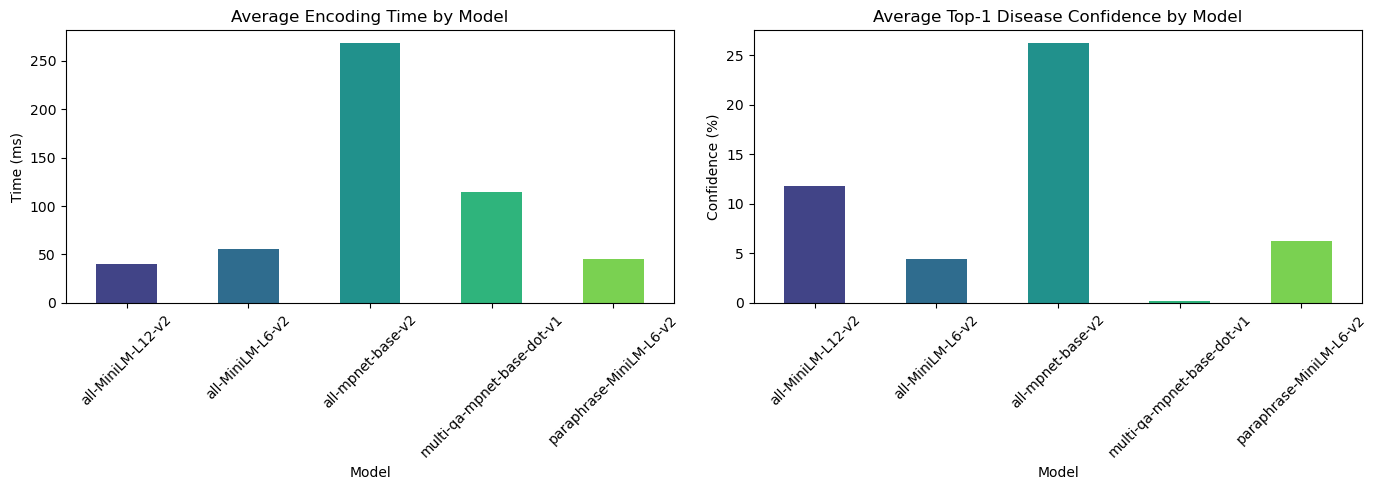

In [10]:
# Visualize encoder speed comparison
df_results = pd.DataFrame(all_results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Encoding time comparison
avg_times = df_results.groupby("model")["encode_time"].mean() * 1000
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(avg_times)))
avg_times.plot(kind="bar", ax=axes[0], color=colors)
axes[0].set_title("Average Encoding Time by Model")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Time (ms)")
axes[0].tick_params(axis='x', rotation=45)

# Confidence comparison
df_results["top_disease_conf"] = df_results["disease_predictions"].apply(lambda x: x[0][1])
avg_conf = df_results.groupby("model")["top_disease_conf"].mean() * 100
avg_conf.plot(kind="bar", ax=axes[1], color=colors)
axes[1].set_title("Average Top-1 Disease Confidence by Model")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Confidence (%)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
# Part 4: Interactive Testing

Enter your own symptom descriptions to test the pipeline.

In [11]:
# Choose which encoder to use for interactive testing
SELECTED_ENCODER = "all-MiniLM-L12-v2"  # Change this to test different encoders

test_encoder = encoders.get(SELECTED_ENCODER, encoder)
print(f"Using encoder: {SELECTED_ENCODER}")

Using encoder: all-MiniLM-L12-v2


In [12]:
# Enter your symptom description here
user_input = "I have a high fever and my body aches all over. I also have a runny nose."

_ = predict_from_text(
    user_input, test_encoder, category_clf, disease_clf,
    category_encoder, disease_encoder, symptom_columns,
    top_k=10
)


INPUT: I have a high fever and my body aches all over. I also have a runny nose.

⏱️  Timing: encode=264.1ms, predict=10.2ms

📊 Detected Symptoms (top 10):
  fever                          0.900 █████████████████
  high fever                     0.900 █████████████████

🏥 Category Predictions:
  Dermatological             40.5% ████████████
  Unknown Type               28.5% ████████
  Musculoskeletal            12.2% ███
  Mental and Behavioral Health   4.8% █
  Genitourinary and Reproductive   3.1% 
  Hematology and Oncology     2.4% 
  Neurological Disorders      2.3% 
  Respiratory System          1.7% 
  Ophthalmology and ENT       1.6% 
  Infectious Diseases         1.3% 

🩺 Disease Predictions:
  pain disorder affecting the neck     16.6% ████
  conductive hearing loss              16.6% ████
  panic disorder                       16.6% ████
  rheumatoid arthritis                 16.6% ████
  migraine                             16.6% ████
  head and neck cancer                

In [13]:
# Batch test with multiple inputs
batch_inputs = [
    "Sharp pain in my lower back that gets worse when I move",
    "My eyes are red and watery, and I keep sneezing",
    "I feel very tired lately and have gained weight unexpectedly",
    "Severe stomach cramps and diarrhea after eating",
    "Numbness in my fingers and toes, especially in cold weather"
]

for text in batch_inputs:
    _ = predict_from_text(
        text, test_encoder, category_clf, disease_clf,
        category_encoder, disease_encoder, symptom_columns
    )


INPUT: Sharp pain in my lower back that gets worse when I move

⏱️  Timing: encode=78.0ms, predict=11.5ms

📊 Detected Symptoms (top 10):
  pain                           0.900 █████████████████
  back swelling                  0.112 ██

🏥 Category Predictions:
  Genitourinary and Reproductive  97.7% █████████████████████████████
  Dermatological              0.9% 
  Gastrointestinal and Hepatic   0.5% 
  Endocrine and Metabolic     0.5% 
  Neurological Disorders      0.1% 

🩺 Disease Predictions:
  phimosis                             50.0% ██████████████
  urethral stricture                   50.0% ██████████████
  neonatal jaundice                     0.0% 
  hydrocele of the testicle             0.0% 
  corneal abrasion                      0.0% 

INPUT: My eyes are red and watery, and I keep sneezing

⏱️  Timing: encode=77.0ms, predict=12.5ms

📊 Detected Symptoms (top 10):
  sneezing                       0.900 █████████████████

🏥 Category Predictions:
  Obstetrics and Neonatal  

---
# Part 5: Symptom Vector Analysis

Analyze how the semantic encoder transforms text into symptom vectors.

In [14]:
def analyze_symptom_vector(text: str, encoder, top_n: int = 15):
    """
    Detailed analysis of how text is encoded into symptom vector.
    """
    result = encoder.encode_symptoms(text)
    vector = result["symptom_vector"]
    
    print(f"\n📝 Input: {text}")
    print(f"{'='*60}")
    
    # Statistics
    non_zero = np.sum(vector > 0.01)
    high_conf = np.sum(vector > 0.5)
    
    print(f"\n📊 Vector Statistics:")
    print(f"  - Non-zero symptoms (>0.01): {non_zero}")
    print(f"  - High confidence (>0.5): {high_conf}")
    print(f"  - Max value: {vector.max():.3f}")
    print(f"  - Mean (non-zero): {vector[vector > 0.01].mean():.3f}")
    
    # Top symptoms
    top_idx = np.argsort(vector)[::-1][:top_n]
    
    print(f"\n🔝 Top {top_n} Symptom Activations:")
    for i in top_idx:
        symptom = encoder.symptoms[i]
        score = vector[i]
        bar = "█" * int(score * 30)
        print(f"  {symptom:35} {score:.3f} {bar}")
    
    return vector

In [15]:
# Analyze symptom vectors for different inputs
analysis_texts = [
    "severe headache with nausea and light sensitivity",
    "chest pain, shortness of breath, and sweating",
    "joint pain and stiffness, especially in the morning"
]

vectors = {}
for text in analysis_texts:
    vectors[text] = analyze_symptom_vector(text, test_encoder)


📝 Input: severe headache with nausea and light sensitivity

📊 Vector Statistics:
  - Non-zero symptoms (>0.01): 6
  - High confidence (>0.5): 2
  - Max value: 0.900
  - Mean (non-zero): 0.321

🔝 Top 15 Symptom Activations:
  headache                            0.900 ██████████████████████████
  nausea                              0.900 ██████████████████████████
  nausea and vomiting                 0.042 █
  lightheadedness                     0.037 █
  vomiting blood                      0.031 
  vomiting                            0.014 
  feeling ill                         0.006 
  blurred vision                      0.006 
  diminished vision                   0.004 
  sensitivity to light                0.003 
  ache all over                       0.003 
  double vision                       0.002 
  mass on ear                         0.002 
  dizziness                           0.000 
  fluid in ear                        0.000 

📝 Input: chest pain, shortness of breath, and 

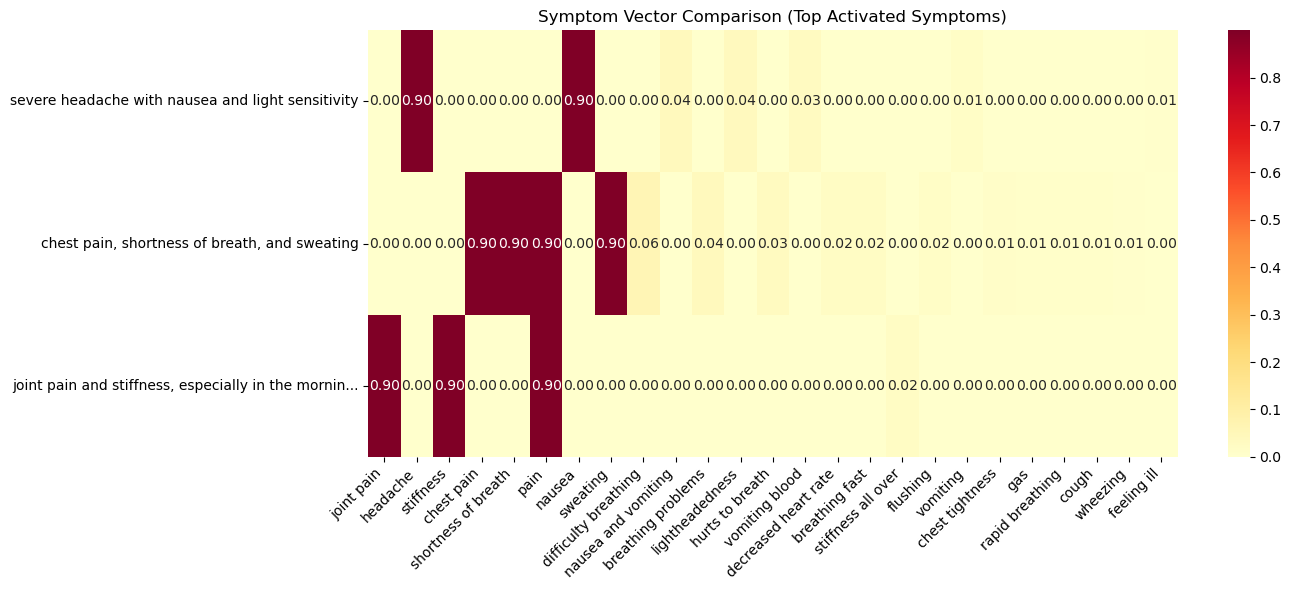

In [16]:
# Visualize symptom vector heatmap
fig, ax = plt.subplots(figsize=(14, 6))

# Get top symptoms across all vectors
all_vectors = np.vstack(list(vectors.values()))
max_per_symptom = all_vectors.max(axis=0)
top_symptom_idx = np.argsort(max_per_symptom)[::-1][:25]

# Create heatmap data
heatmap_data = np.array([v[top_symptom_idx] for v in vectors.values()])
symptom_names = [test_encoder.symptoms[i] for i in top_symptom_idx]

sns.heatmap(heatmap_data, xticklabels=symptom_names, 
            yticklabels=[t[:50] + "..." if len(t) > 50 else t for t in vectors.keys()],
            cmap="YlOrRd", annot=True, fmt=".2f", ax=ax)

ax.set_title("Symptom Vector Comparison (Top Activated Symptoms)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
# Part 6: Encoder Similarity Analysis

Explore semantic similarity between symptoms using the encoder.

In [17]:
# Find similar symptoms
query_symptoms = [
    "headache",
    "chest pain",
    "fatigue",
    "cough",
    "anxiety"
]

print("Semantically Similar Symptoms:")
print("=" * 60)

for symptom in query_symptoms:
    similar = test_encoder.get_similar_symptoms(symptom, top_k=5)
    print(f"\n{symptom}:")
    for s, score in similar:
        print(f"  → {s} ({score:.3f})")

Semantically Similar Symptoms:

headache:
  → dizziness (0.818)
  → neck pain (0.793)
  → fever (0.786)
  → frontal headache (0.785)
  → side pain (0.784)

chest pain:
  → sharp chest pain (0.869)
  → rib pain (0.868)
  → burning chest pain (0.828)
  → congestion in chest (0.820)
  → chest tightness (0.808)

fatigue:
  → depression (0.782)
  → hesitancy (0.776)
  → weakness (0.768)
  → nausea (0.761)
  → mood changes (0.761)

cough:
  → sneezing (0.760)
  → wheezing (0.746)
  → coughing up sputum (0.741)
  → vomiting (0.736)
  → paralysis (0.731)

anxiety:
  → depression (0.792)
  → paralysis (0.747)
  → hallucinations (0.742)
  → anxiety and nervousness (0.737)
  → delirium (0.722)


In [18]:
# Test with informal/colloquial symptom descriptions
informal_to_medical = [
    ("my head is killing me", "headache"),
    ("can't catch my breath", "shortness of breath"),
    ("throwing up", "vomiting"),
    ("feeling dizzy", "dizziness"),
    ("can't sleep", "insomnia"),
    ("tummy hurts", "abdominal pain"),
]

print("Informal → Medical Symptom Mapping:")
print("=" * 70)

for informal, expected in informal_to_medical:
    result = test_encoder.encode_symptoms(informal)
    vector = result["symptom_vector"]
    top_idx = np.argsort(vector)[::-1][0]
    top_symptom = test_encoder.symptoms[top_idx]
    top_score = vector[top_idx]
    
    match = "✓" if expected in top_symptom or top_symptom in expected else "✗"
    print(f"{match} '{informal}' → {top_symptom} ({top_score:.3f})  [expected: {expected}]")

Informal → Medical Symptom Mapping:
✓ 'my head is killing me' → headache (0.004)  [expected: headache]
✗ 'can't catch my breath' → flushing (0.031)  [expected: shortness of breath]
✓ 'throwing up' → vomiting (0.077)  [expected: vomiting]
✓ 'feeling dizzy' → dizziness (0.102)  [expected: dizziness]
✓ 'can't sleep' → insomnia (0.080)  [expected: insomnia]
✗ 'tummy hurts' → coryza (0.008)  [expected: abdominal pain]


In [19]:
print("\n" + "="*70)
print("✓ Test Pipeline Complete!")
print("="*70)
print("\nSummary:")
print(f"  - Tested {len(ENCODER_MODELS)} different semantic encoder models")
print(f"  - Pipeline: Text → {len(test_encoder.symptoms)}-dim symptom vector → Classifier")
print(f"  - Categories: {len(category_encoder.classes_)}")
print(f"  - Diseases: {len(disease_encoder.classes_)}")


✓ Test Pipeline Complete!

Summary:
  - Tested 5 different semantic encoder models
  - Pipeline: Text → 454-dim symptom vector → Classifier
  - Categories: 14
  - Diseases: 656
